# Промышленость

Для оптимизации производственных расходов, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали.

**Целью проекта** является построение модели предсказывающая температуру стали, которая в дальнейшем минимизирует расходы электроэнергии.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## План решения задачи

- Импортировать данные, провести исследовательский анализ данных
- Провести предобработку данных

- Подготовить данные:
    - Определить признаки необхимые для нашей будущей модели
    - Удалить ненужные данные
    
    
- Соединить все нужные данные в одну таблицу с признаками key
- Выбирать признаки и целевой признак
- Выделить 30% тестовых данных из всего объема данных, и проверить на тестовой выборке
- Использовать XGBoost, CatBoost и LinearRegression с подбором нужных параметров
- Сравнить полученные результаты наших моделей и выделим лучшую

## Анализ данных

### Открытие данных

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

In [ ]:
def data_read(file):
    """
        Функция принемает путь к файлу, выводить на экран 10 сторк таблицы,
        информацию о столбцах, число дубликатов и возврашет таблицу типа DataFrame
    """
    data = pd.read_csv(file)
    display(data.head(10))
    display(data.describe())
    data.info(memory_usage='deep')
    print("\n"+'Количество дубликатов:', data.duplicated().sum())
    print("\n"+'Колическтво пустых значений')
    df_null = data.isnull().sum()
    print(df_null[df_null>0].sort_values(ascending=False))
    print("\n"+'Процент пустых значений')
    df_null_p = df_null/len(data)*100
    print(df_null_p[df_null_p>0].sort_values(ascending=False))
    return data

**Данные об электродах**

In [ ]:
df_arc = data_read('/datasets/final_steel/data_arc.csv')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.5 MB

Количество дубликатов: 0

Колическтво пустых значений
Series([], dtype: int64)

Процент пустых значений
Series([], dtype: float64)


In [ ]:
def sns_hists(data, data_label, bins):
    """
    Функция на вход принемает датафрейм и названия столбцов датафрейма.
    Выводом функции является цикл гистограмм каждого столбца датафрейма.
    """
    sns.set()
    plt.figure(figsize=(16, 6))
    plt.title('Гистограмма столбца ' + data_label, fontsize=18)
    plt.ylabel('Частота', fontsize=15)
    sns.distplot(data[data_label], bins=bins)
    plt.show()

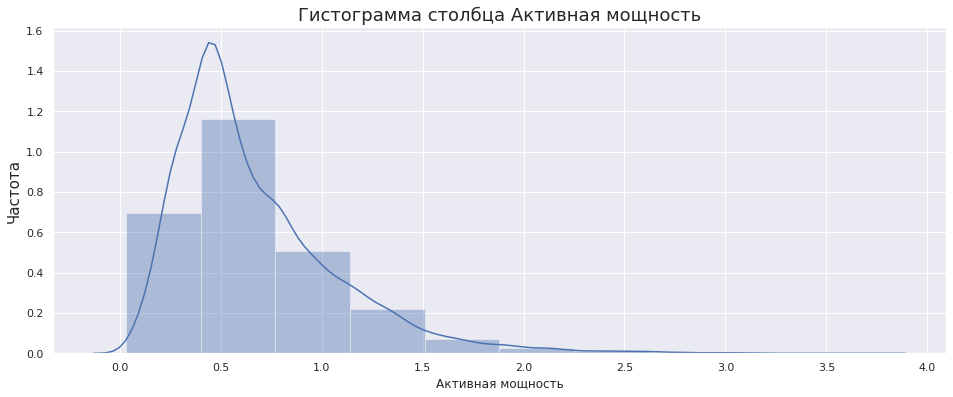

In [ ]:
sns_hists(df_arc, 'Активная мощность', 10)

Активное мощность имеет нормальное распределение со сдвигом в лево.

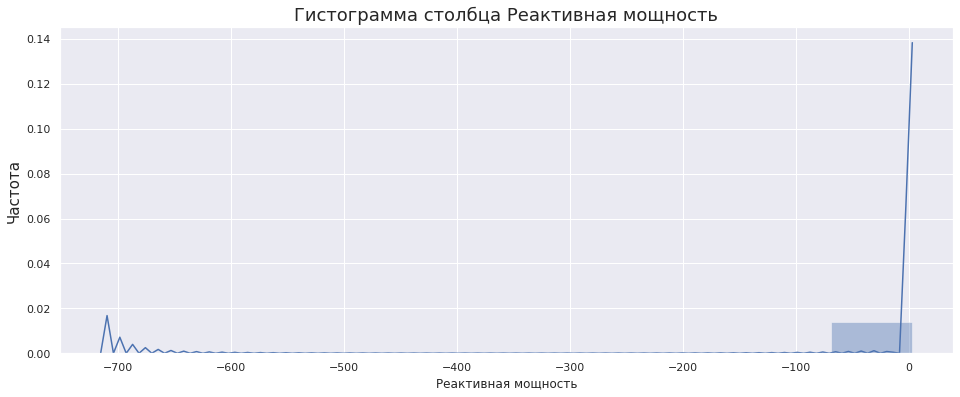

In [ ]:
sns_hists(df_arc, 'Реактивная мощность', 10)

По гистограмме реактивной мощности видны выбивающееся значение ниже нуля. Необходимо отбросить отрицательные значения.

Выводы по таблице:
* Таблица не имеет пустых значений;
* Дубликатов нет;
* Наблюдаются аномальные значения, например, в "Реактивной мощности" значение -715 говорит об ошибке при измерениях;;
* На основе данных реактивной и активной мощности необходимо посчитать полную мощность.

**Данные о подаче сыпучих материалов (объём)**

In [ ]:
df_bulk = data_read('/datasets/final_steel/data_bulk.csv')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Количество дубликатов: 0

Колическтво пустых значений
Bulk 8     3128
Bulk 13    3111
Bulk 9     3110
Bulk 2     3107
Bulk 7     3104
Bulk 5     3052
Bulk 10    2953
Bulk 11    2952
Bulk 1     2877
Bulk 6     2553
Bulk 4     2115
Bulk 3     1831
Bulk 15     881
Bulk 12     679
Bulk 14     323
dtype: int64

Процент пустых значени

В таблице нет дубликатов. Имеется большое количество пустых значений.

**Данные о подаче сыпучих материалов (время)**

In [ ]:
df_bulk_time = data_read('/datasets/final_steel/data_bulk_time.csv')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 1.9 MB

Количество дубликатов: 0

Колическтво пустых значений
Bulk 8     3128
Bulk 13    3111
Bulk 9     3110
Bulk 2     3107
Bulk 7     3104
Bulk 5     3052
Bulk 10    2953
Bulk 11    2952
Bulk 1     2877
Bulk 6     2553
Bulk 4     2115
Bulk 3     1831
Bulk 15     881
Bulk 12     679
Bulk 14     323
dtype: int64

Процент пустых значений
Bulk 8     99.96

Также как и в предыдущей таблице в данной таблице нет дубликатов. Имеется большое количество пустых значений. Для построения модели данные из таблицы выше не понадобятся.

**Данные о продувке сплава газом**

In [ ]:
df_gas = data_read('/datasets/final_steel/data_gas.csv')

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Количество дубликатов: 0

Колическтво пустых значений
Series([], dtype: int64)

Процент пустых значений
Series([], dtype: float64)


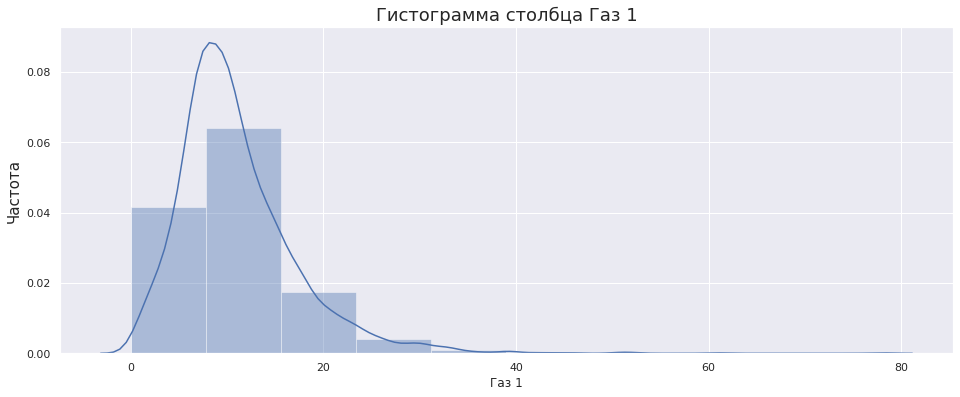

In [ ]:
sns_hists(df_gas, 'Газ 1', 10)

Вывод:

* типы данных записаны правильно
* в таблице нет пустых значений
* нет дубликатов
* гистограмма столбца газ показала, что аномальных значений нет, и гистограмма имеет нормальное распределение.

**Результаты измерения температуры**

In [ ]:
df_temp = data_read('/datasets/final_steel/data_temp.csv')

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.4 MB

Количество дубликатов: 0

Колическтво пустых значений
Температура    2901
dtype: int64

Процент пустых значений
Температура    18.237254
dtype: float64


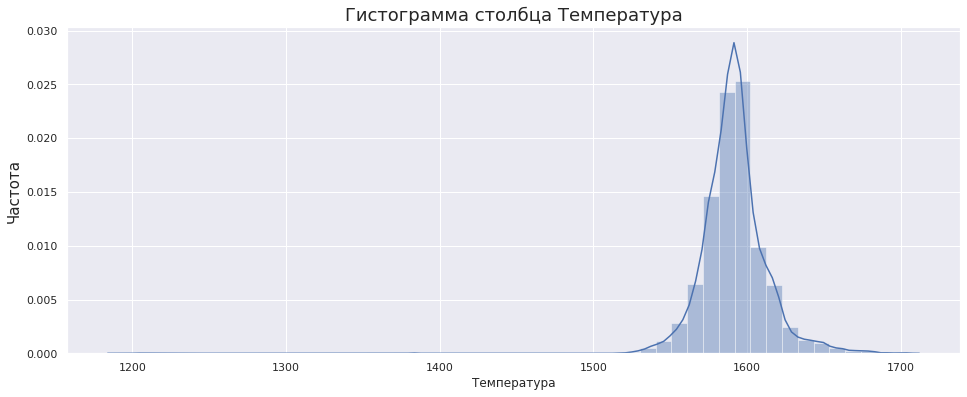

In [ ]:
sns_hists(df_temp, 'Температура', 50)

Гистограмма имеет нормально распределения температуры со смещением в право.

In [ ]:
df_temp[df_temp['Температура'].isnull()].head(10)

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
12277,2502,2019-08-06 04:46:04,NaN
12278,2502,2019-08-06 04:52:32,NaN
12279,2502,2019-08-06 04:57:30,NaN


In [ ]:
df_temp[df_temp['Температура'].isnull()].tail()

,key,Время замера,Температура
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


Вывод:

* Имеется пустые значения, которые можно удалить
* дубликатов нет
* столбец температуры будет использоваться в качестве целевого признака при построения модели
* Начиная с 2500 партии наблюдаем пропущенные значения
* гистограмма имеет нормально распределения температуры со смещением в право.

**Данные о проволочных материалах (объём)**

In [ ]:
df_wire = data_read('/datasets/final_steel/data_wire.csv')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Количество дубликатов: 0

Колическтво пустых значений
Wire 5    3080
Wire 7    3070
Wire 4    3067
Wire 8    3062
Wire 9    3052
Wire 3    3018
Wire 6    3008
Wire 2    2002
Wire 1      26
dtype: int64

Процент пустых значений
Wire 5    99.967543
Wire 7    99.642973
Wire 4    99.545602
Wire 8    99.383317
Wire 9    99.058747
Wire 3    97.955209
Wire 6    97.630639
Wire 2    64.978903
Wire 1     0.843882
dtype: float64


В таблице нет дубликатов. Имеется большое количество пустых значений.

**Данные о проволочных материалах (время)**

In [ ]:
df_wire_time = data_read('/datasets/final_steel/data_wire_time.csv')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 1.1 MB

Количество дубликатов: 0

Колическтво пустых значений
Wire 5    3080
Wire 7    3070
Wire 4    3067
Wire 8    3062
Wire 9    3052
Wire 3    3018
Wire 6    3008
Wire 2    2002
Wire 1      26
dtype: int64

Процент пустых значений
Wire 5    99.967543
Wire 7    99.642973
Wire 4    99.545602
Wire 8    99.383317
Wire 9    99.058747
Wire 3    97.955209
Wire 6    97.630639
Wire 2    64.978903
Wire 1     0.843882
dtype: float64


Также как и в предыдущей таблице в данной таблице нет дубликатов. Имеется большое количество пустых значений. Для построения модели данные из таблицы выше не понадобятся.

### Вывод

В данном пункте:

* Загрузили и изучили данные.
* Выялены аномальные значения.
* Проверили данные на пропуски и дубликаты.
* В значениях температуры таблицы отсутствуют данные начиная с 2500й партии, поэтому в дальнейшем нужно будет провести срез данных начиная с 2500 партии.
* Таблицы  "Данные о подаче сыпучих материалов (время)" и "Данные о проволочных материалах (время)" не понадобятся для построения модели.
* Столбцы даты и времени в дальнейшем не понадобятся, следовательно их нужно удалить.

## Предобработка данных

### План

* Удалить аномалии из таблицы Данные об электродах
* Посчитать полную мощность
* Удалить пустые значения из таблицы Результаты измерения температуры, и исключить столбцы даты времени из таблиц df_arc, df_gas, df_temp
* Соединить таблицы df_arc, df_gas, df_temp по полю key
* Выделить признаки и целевой признак
* Произвести стандартизацию данных
* Разделить выборки на тестовою и тренировочною

**Удалим аномалии в реактивной мощности из таблицы Данные об электродах**

In [ ]:
df_arc = df_arc[df_arc['Реактивная мощность'] >= 0]
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
key                     14875 non-null int64
Начало нагрева дугой    14875 non-null object
Конец нагрева дугой     14875 non-null object
Активная мощность       14875 non-null float64
Реактивная мощность     14875 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 697.3+ KB


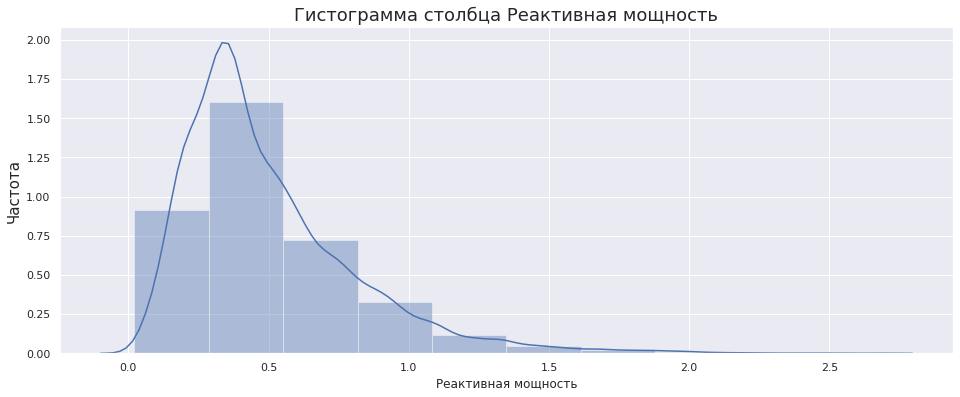

In [ ]:
sns_hists(df_arc, 'Реактивная мощность', 10)

После удаления одного аномального значения из реактивной мощности гистограмма имеет нормальное распределение.

**Полная мощность**

соотношение полной мощности с активной и реактивной мощностями выражается в следующем виде:
    $$  S  = {\sqrt{P^2 + Q^2}} $$
    где P — активная мощность, Q — реактивная мощность.

In [ ]:
full_power = np.sqrt(df_arc['Активная мощность']**2 + df_arc['Реактивная мощность']**2)
df_arc['Полная мощность'] = full_power

In [ ]:
df_arc = df_arc.drop(['Активная мощность', 'Реактивная мощность'], axis=1)

Посчитаем количество итераций нагрева и сгруппируем данные по партиям

In [ ]:
df_arc_iter = df_arc.groupby(by = 'key', as_index = False).count()[['key', 'Начало нагрева дугой']]
df_arc_iter.columns = ['key', 'Количество итераций нагрева']

df_arc = df_arc.groupby(by = 'key', as_index = False).sum()

df_arc = df_arc.merge(df_arc_iter, how = 'left', on = 'key')

df_arc.head()

,key,Полная мощность,Количество итераций нагрева
0,1,5.826395,5
1,2,3.649216,4
2,3,2.989534,5
3,4,3.814962,4
4,5,4.035758,4


Удалим партии более 2500, т.к. для них отсутствует значение температуры

In [ ]:
df_wire = df_wire.query('key < 2500')
df_bulk = df_bulk.query('key < 2500')
df_arc = df_arc.query('key < 2500')
df_temp = df_temp.query('key < 2500')
df_gas = df_gas.query('key < 2500')

Удалим строки с пропусками данных

In [ ]:
df_temp = df_temp.dropna()
df_temp = df_temp.sort_values(by=['Время замера'])
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12267 entries, 0 to 12266
Data columns (total 3 columns):
key             12267 non-null int64
Время замера    12267 non-null object
Температура     12267 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 383.3+ KB


Уберем из таблицы df_temp партии с одной температурой, а также сгруппируем данные по партиям, и выделим начальную и конечную температуры

In [ ]:
count = df_temp.groupby(by = 'key', as_index = False).count()
one = count[count['Время замера'] == 1]['key'].tolist()
df_temp = df_temp.query('key not in @one')

In [ ]:
df_temp = df_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
df_temp.columns = df_temp.columns.droplevel()
df_temp.columns = ['key', 'Время замера 1', 'Время замера 2', 'Температура 1', 'Температура 2']
df_temp = df_temp[['key', 'Температура 1', 'Температура 2']]

**Соединим таблицы df_arc, df_gas, df_temp по полю key**

In [ ]:
df = (df_temp.merge(df_arc, how = 'left', on = 'key')
            .merge(df_wire, how = 'left', on = 'key')
            .merge(df_bulk, how = 'left', on = 'key')
            .merge(df_gas, how = 'left', on = 'key'))

df = df.drop(['key'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 29 columns):
Температура 1                  2475 non-null float64
Температура 2                  2475 non-null float64
Полная мощность                2475 non-null float64
Количество итераций нагрева    2475 non-null int64
Wire 1                         2348 non-null float64
Wire 2                         833 non-null float64
Wire 3                         39 non-null float64
Wire 4                         12 non-null float64
Wire 5                         0 non-null float64
Wire 6                         45 non-null float64
Wire 7                         4 non-null float64
Wire 8                         13 non-null float64
Wire 9                         28 non-null float64
Bulk 1                         199 non-null float64
Bulk 2                         13 non-null float64
Bulk 3                         965 non-null float64
Bulk 4                         814 non-null float64
Bulk 5          

Заполним пустые значения нулями. Также удалим признаки, где пустых значений около 99%

In [ ]:
df = df.drop(['Wire 5','Wire 3', 'Wire 7', 'Wire 8', 'Wire 9'
              ,'Bulk 8', 'Bulk 13', 'Bulk 9','Bulk 2'], axis=1)
df = df.fillna(0)
df.head()

,Температура 1,Температура 2,Полная мощность,Количество итераций нагрева,Wire 1,Wire 2,Wire 4,Wire 6,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Газ 1
0,1571.0,1613.0,5.826395,5,60.059998,0.00000,0.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,29.749986
1,1581.0,1602.0,3.649216,4,96.052315,0.00000,0.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,12.555561
2,1596.0,1599.0,2.989534,5,91.160157,0.00000,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,28.554793
3,1601.0,1625.0,3.814962,4,89.063515,0.00000,0.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,18.841219
4,1576.0,1602.0,4.035758,4,89.238236,9.11456,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,5.413692


**Выделим признаки**

In [ ]:
features = df.drop(['Температура 2'], axis=1)
target = df['Температура 2']

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                              test_size=0.30, random_state=12345)
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((1732, 19), (743, 19), (1732,), (743,))

**Стандартизация признаков**

In [ ]:
numeric = ['Полная мощность', 'Газ 1']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
pd.options.mode.chained_assignment = None
features_train[numeric] = scaler.transform(features_train[numeric])

features_test[numeric] = scaler.transform(features_test[numeric])

**Вывод:**

В данном пункте произведены следующие действия:

* Удалены аномалии и пустые значения
* Посчитана полная мощность
* Соединены таблицы
* Выделить признаки и целевой признак
* Выборка разделена в соотношении 70 на 30
* Произведена стандартизация данных